In [20]:
import pandas as pd
import json
import time
import openai
import os
from dotenv import load_dotenv

load_dotenv()

# ✅ 初始化 OpenAI 客户端（建议使用环境变量 OPENAI_API_KEY）
API_KEY = os.getenv("OPENAI_API_KEY")
client = openai.Client(api_key=API_KEY)

# ✅ 读取子问 + 背景 的 CSV
df = pd.read_csv("unsw.csv")

# ✅ 构造带背景的 prompt 模板

def build_prompt(full_question, subquestion):
    return f"""You are a statistics master student.

Here is the full background of the problem:
{full_question}

Now, please solve the following sub-question step-by-step using structured reasoning:

{subquestion}

For each step, return a JSON object with:
- step: the step number (or "final" if it's the final answer),
- desc: a short description of what you are doing,
- expr: a math expression if applicable,
- value: the computed result if any

Format the full output as a JSON array of steps.
Return ONLY a valid JSON array. No explanations. No markdown.
"""

# ✅ GPT 调用函数（同样支持 debug 保存 + 容错）
def call_gpt4o(prompt, qid, subid, model="gpt-4o"):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        reply = response.choices[0].message.content.strip()

        # 清理 markdown
        if reply.startswith("```json"):
            reply = reply.removeprefix("```json").removesuffix("```").strip()
        elif reply.startswith("```"):
            reply = reply.removeprefix("```").removesuffix("```").strip()

        return json.loads(reply)

    except json.JSONDecodeError as jde:
        print(f"❌ JSON 解析失败（{qid}-{subid}）：", jde)
        return [{"step": "error", "desc": "Invalid JSON output", "raw": reply[:300]}]
    except Exception as e:
        print(f"❌ API 调用失败（{qid}-{subid}）：", e)
        return [{"step": "error", "desc": str(e)}]

# ✅ 主流程：逐子问处理
solutions = []

for _, row in df.iterrows():
    qid = row["qid"]
    subid = row["subid"]
    subq = row["subquestion"]
    fullq = row["full_question"]

    print(f"\n🧠 解题中：{qid}-{subid}")

    prompt = build_prompt(fullq, subq)
    steps = call_gpt4o(prompt, qid, subid)

    solutions.append({
        "qid": qid,
        "subid": subid,
        "subquestion": subq,
        "full_question": fullq,
        "steps": steps
    })

    time.sleep(2)

# ✅ 保存所有结果
with open("gpt4o_subquestion_solutions.json", "w") as f:
    json.dump(solutions, f, indent=2, ensure_ascii=False)

print("\n✅ 所有子问解题完毕！结果已保存为 gpt4o_subquestion_solutions.json")

import math

# ✅ 递归清洗 NaN 为 None（合法 JSON 的 null）
def clean_nan(obj):
    if isinstance(obj, float) and math.isnan(obj):
        return None
    elif isinstance(obj, list):
        return [clean_nan(x) for x in obj]
    elif isinstance(obj, dict):
        return {k: clean_nan(v) for k, v in obj.items()}
    else:
        return obj

# ✅ 应用于整个 solutions 列表
cleaned_solutions = clean_nan(solutions)

# ✅ 保存为合法 JSON 文件
with open("gpt4o_subquestion_solutions.json", "w") as f:
    json.dump(cleaned_solutions, f, indent=2, ensure_ascii=False)

print("\n✅ 清洗后保存完毕（NaN → null），文件已生成：gpt4o_subquestion_solutions.json")


🧠 解题中：Problemone-nan

🧠 解题中：Problemtwo-i

🧠 解题中：Problemtwo-ii

🧠 解题中：Problemtwo-iii

🧠 解题中：Problemthree-nan

🧠 解题中：Problemfour-nan

🧠 解题中：Problemone-i

🧠 解题中：Problemone-ii

🧠 解题中：Problemone-iii

🧠 解题中：Problemone-iv

🧠 解题中：Problemtwo-nan

🧠 解题中：Problemthree-i

🧠 解题中：Problemthree-ii

🧠 解题中：Problemthree-iii

🧠 解题中：Problemthree-iv

🧠 解题中：Problemone-1ia

✅ 所有子问解题完毕！结果已保存为 gpt4o_subquestion_solutions.json

✅ 清洗后保存完毕（NaN → null），文件已生成：gpt4o_subquestion_solutions.json


In [21]:
import requests

# Load environment variables
load_dotenv()
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
DEEPSEEK_API_URL = "https://api.deepseek.com/v1/chat/completions"  # Verify endpoint

# Load GPT-generated solutions
with open("gpt4o_subquestion_solutions.json") as f:
    solutions = json.load(f)

# Grading prompt template (保持不变)
def build_grading_prompt(subquestion, steps_json):
    steps_str = json.dumps(steps_json, indent=2, ensure_ascii=False)
    return f"""You are a statistics tutor. Please grade a student's step-by-step solution to a sub-question.

Sub-question:
{subquestion}

Student's steps:
{steps_str}

Now, do the following:
1. Evaluate if each step is correct or flawed. If flawed, explain why.
2. Give a short comment for each step.
3. Give an overall score out of 5 and a short feedback.
4. Use the following scoring rubric:
   1 - Completely incorrect: Major logical flaws, fundamental misunderstandings, or missing core steps. Lacks basic understanding.
   2 - Weak: Some grasp of the method, but contains multiple errors, flawed reasoning, or incoherent structure.
   3 - Satisfactory: Main method is correct, includes key steps, but has some calculation or explanation issues.
   4 - Good: Mostly correct, logically structured, only minor issues such as small errors or slightly informal reasoning.
   5 - Excellent: Fully correct, well-organized, rigorous and clear reasoning. A model solution.
5. Format your output as the following JSON:

{{
  "score": X,
  "total": 5,
  "feedback": "...",
  "step_feedback": [{{"step": ..., "comment": "..."}}, ...]
}}
Return ONLY a valid JSON object. No markdown, no extra explanation.
"""

# Modified DeepSeek grading function
def grade_with_deepseek(question, steps, qid, subid, model="deepseek-chat"):
    prompt = build_grading_prompt(question, steps)
    try:
        headers = {
            "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
            "Content-Type": "application/json"
        }
        payload = {
            "model": model,
            "messages": [{"role": "user", "content": prompt}],
            "temperature": 0
        }

        response = requests.post(DEEPSEEK_API_URL, headers=headers, json=payload)
        response.raise_for_status()
        
        reply = response.json()["choices"][0]["message"]["content"].strip()
        
        # Clean markdown formatting
        if reply.startswith("```json"):
            reply = reply[7:-3].strip()
        elif reply.startswith("```"):
            reply = reply[3:-3].strip()

        return json.loads(reply)

    except json.JSONDecodeError as jde:
        print(f"❌ JSON parsing failed ({qid}-{subid}):", jde)
        return {"score": 0, "total": 5, "feedback": "Invalid JSON output", "step_feedback": []}
    except requests.exceptions.RequestException as re:
        print(f"❌ API request failed ({qid}-{subid}):", re)
        return {"score": 0, "total": 5, "feedback": f"API Error: {str(re)}", "step_feedback": []}
    except Exception as e:
        print(f"❌ Unexpected error ({qid}-{subid}):", e)
        return {"score": 0, "total": 5, "feedback": str(e), "step_feedback": []}

# Batch grading with DeepSeek
graded_results = []
for item in solutions:
    qid = item["qid"]
    subid = item["subid"]
    question = item["subquestion"]
    steps = item["steps"]

    print(f"📝 Grading: {qid}-{subid}")
    grading = grade_with_deepseek(question, steps, qid, subid)

    graded_results.append({
        "qid": qid,
        "subid": subid,
        "subquestion": question,
        "score": grading.get("score", 0),
        "total": grading.get("total", 5),
        "feedback": grading.get("feedback", ""),
        "step_feedback": grading.get("step_feedback", [])
    })

    time.sleep(1)  # Rate limiting

# Save grading results
with open("deepseek_grading_results.json", "w", encoding='utf-8') as f:
    json.dump(graded_results, f, indent=2, ensure_ascii=False)

print("✅ All sub-questions graded and saved as deepseek_grading_results.json")

📝 Grading: Problemone-None
📝 Grading: Problemtwo-i
📝 Grading: Problemtwo-ii
📝 Grading: Problemtwo-iii
📝 Grading: Problemthree-None
📝 Grading: Problemfour-None
📝 Grading: Problemone-i
📝 Grading: Problemone-ii
📝 Grading: Problemone-iii
📝 Grading: Problemone-iv
📝 Grading: Problemtwo-None
📝 Grading: Problemthree-i
📝 Grading: Problemthree-ii
📝 Grading: Problemthree-iii
📝 Grading: Problemthree-iv
📝 Grading: Problemone-1ia
✅ All sub-questions graded and saved as deepseek_grading_results.json


In [30]:
import json

# 读取评分结果
with open("deepseek_grading_results.json", "r", encoding="utf-8") as f:
    graded = json.load(f)

# 筛选出不是满分的子问，并记录其原始索引
wrong = []
for idx, item in enumerate(graded):
    if item.get("score", 0) < item.get("total", 5):
        item_with_index = item.copy()
        item_with_index["index"] = idx  # 添加原始索引
        wrong.append(item_with_index)

# 保存为 json
with open("wrong_subquestions.json", "w", encoding="utf-8") as f:
    json.dump(wrong, f, indent=2, ensure_ascii=False)

print(f"✅ 筛选出 {len(wrong)} 道错题，保存为 wrong_subquestions.json，并记录其原始索引。")

✅ 筛选出 66 道错题，保存为 wrong_subquestions.json，并记录其原始索引。


In [31]:
import json
from collections import defaultdict, Counter
import pandas as pd

# ✅ 读取评分文件
with open("deepseek_grading_results.json", "r", encoding="utf-8") as f:
    graded = json.load(f)

# ✅ 定义课程类别对应的题目索引范围
category_ranges = {
    "Statistical Inference": range(0, 39),
    "Computational Methods for Finance": range(39, 119),
    "Optimization": range(119, 134)
}

# ✅ 初始化统计容器
category_distribution = defaultdict(lambda: {"score_counts": Counter(), "total": 0})

# ✅ 遍历评分数据，按 index 分类计分
for idx, item in enumerate(graded):
    for category, index_range in category_ranges.items():
        if idx in index_range:
            score = item.get("score", 0)
            total_score = item.get("total", 5)
            category_distribution[category]["score_counts"][score] += 1
            category_distribution[category]["total"] += 1
            break

# ✅ 构建 summary 表格
summary_data = []
for category, data in category_distribution.items():
    total_questions = data["total"]
    full_score = max(data["score_counts"].keys(), default=5)
    accuracy = data["score_counts"].get(full_score, 0) / total_questions if total_questions > 0 else 0

    row = {
        "课程类别": category,
        "题目总数": total_questions,
        "准确率": f"{accuracy:.2%}"
    }

    # 每个得分段的题数 + 占比
    for score in range(full_score + 1):
        count = data["score_counts"].get(score, 0)
        row[f"得分 {score} 数"] = count
        row[f"得分 {score} 占比"] = f"{(count / total_questions):.1%}" if total_questions > 0 else "0%"

    summary_data.append(row)

# ✅ 输出为 DataFrame（可打印或保存）
df_summary = pd.DataFrame(summary_data)
print(df_summary)

# ✅ 可选：保存为 CSV 文件
df_summary.to_csv("score_distribution_by_category.csv", index=False, encoding="utf-8-sig")


                                课程类别  题目总数     准确率  得分 0 数 得分 0 占比  得分 1 数  \
0              Statistical Inference    39  58.97%       0    0.0%       0   
1  Computational Methods for Finance    80  47.50%       0    0.0%       0   
2                       Optimization    15  46.67%       0    0.0%       0   

  得分 1 占比  得分 2 数 得分 2 占比  得分 3 数 得分 3 占比  得分 4 数 得分 4 占比  得分 5 数 得分 5 占比  
0    0.0%       0    0.0%       3    7.7%      13   33.3%      23   59.0%  
1    0.0%       1    1.2%       7    8.8%      34   42.5%      38   47.5%  
2    0.0%       0    0.0%       0    0.0%       8   53.3%       7   46.7%  


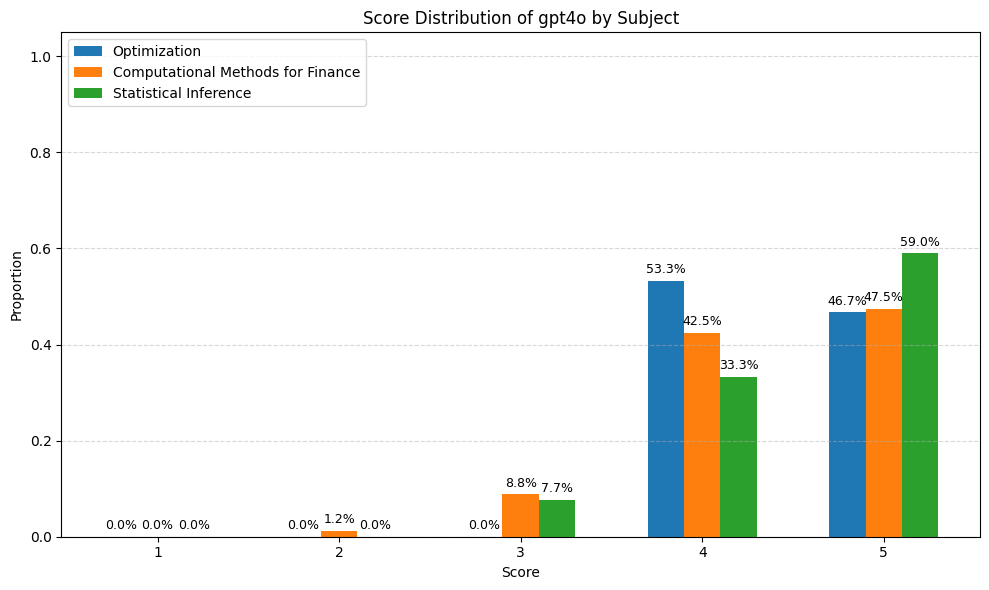

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 你希望的科目顺序
custom_order = ["Optimization", "Computational Methods for Finance", "Statistical Inference"]
score_levels = [1, 2, 3, 4, 5]

# 提取占比数据
subject_ratios = {
    cat: [
        float(df_summary[df_summary["课程类别"] == cat][f"得分 {score} 占比"].values[0].strip('%')) / 100
        for score in score_levels
    ]
    for cat in custom_order
}

# 转换为矩阵（score 为横轴）
ratios_matrix = np.array(list(subject_ratios.values())).T  # shape: (num_scores, num_categories)

# 设置画布与参数
bar_width = 0.2
x = np.arange(len(score_levels))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # 蓝 橙 绿，对应你要求的科目顺序

plt.figure(figsize=(10, 6))

# 画每门课的柱状图
for i, cat in enumerate(custom_order):
    offsets = x + (i - 1) * bar_width
    heights = ratios_matrix[:, i]
    bars = plt.bar(offsets, heights, width=bar_width, label=cat, color=colors[i])

    # 添加百分比标签
    for bar, height in zip(bars, heights):
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f"{height:.1%}", ha='center', va='bottom', fontsize=9)

# 图形修饰
plt.xticks(x, [str(s) for s in score_levels])
plt.xlabel("Score")
plt.ylabel("Proportion")
plt.ylim(0, 1.05)
plt.title("Score Distribution of gpt4o by Subject")
plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()